In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider
from tqdm import tqdm

%matplotlib inline

C:\Users\a0922\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\a0922\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\a0922\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
train_acl = pd.read_csv('train-acl.csv', names=['Case', 'Abnormal'], header=None, dtype={'Case':str, 'Abnormal': np.int64})
train_acl.head()

,Case,Abnormal
0,0000,0
1,0001,1
2,0002,0
3,0003,0
4,0004,0


In [3]:
train_acl.shape

(1130, 2)

In [4]:
train_acl.Abnormal.value_counts(normalize=True)

0    0.815929
1    0.184071
Name: Abnormal, dtype: float64

In [5]:
case = '0000'
mri_coronal = np.load('train/coronal/0000.npy')
mri_axial = np.load('train/axial/0000.npy')
mri_sagittal = np.load('train/sagittal/0000.npy')

print('MRI scan on coronal plane : {}'.format(mri_coronal.shape))
print('MRI scan on axial plane : {}'.format(mri_axial.shape))
print('MRI scan on sagittal plane : {}'.format(mri_sagittal.shape))

MRI scan on coronal plane : (36, 256, 256)
MRI scan on axial plane : (44, 256, 256)
MRI scan on sagittal plane : (36, 256, 256)


# Visualize the first one on each plane

Text(0.5, 1.0, 'Case  0 | Slice 1 | Sagittal')

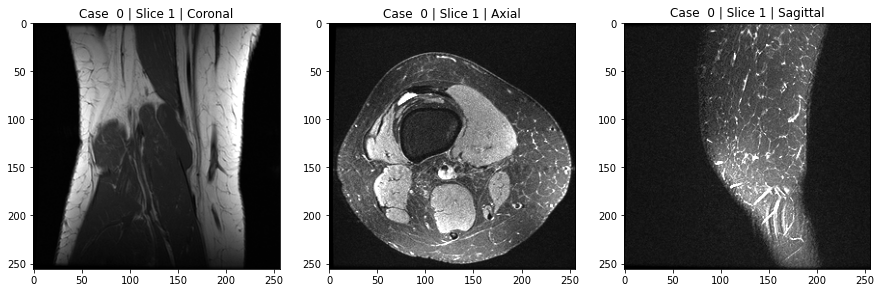

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.imshow(mri_coronal[0, :, :], 'gray')
ax1.set_title('Case  0 | Slice 1 | Coronal')

ax2.imshow(mri_axial[0, :, :], 'gray')
ax2.set_title('Case  0 | Slice 1 | Axial')

ax3.imshow(mri_sagittal[0, :, :], 'gray')
ax3.set_title('Case  0 | Slice 1 | Sagittal')


# Make an interactive widget

In [7]:
train_path = 'train/'

def load_one_stack(case, data_path=train_path, plane='coronal'):
    fpath = '{}/{}/{}.npy'.format(train_path, plane, case)
    return np.load(fpath)

def load_stacks(case, data_path=train_path):
    x = {}
    planes = ['coronal', 'axial', 'sagittal']
    for i, plane in enumerate(planes):
        x[plane] = load_one_stack(case, plane=plane)
    return x

def load_cases(train=True, n=None):
    assert (type(n) == int) and (n < 1250)
    if train:
        case_list = pd.read_csv('train-acl.csv', names=['Case', 'Abnormal'], header=None, 
                                dtype={'Case':str, 'Abnormal': np.int64})['Case'].tolist()
    else:
        case_list = pd.read_csv('valid-acl.csv', names=['Case', 'Abnormal'], header=None, 
                                dtype={'Case':str, 'Abnormal': np.int64})['Case'].tolist()
        
    cases = {}
    
    if n is not None:
        case_list = case_list[:n]
        
    for case in tqdm(case_list):
        x = load_stacks(case)
        cases[case] = x
    return cases

cases = load_cases(n=100)

100%|██████████| 100/100 [00:12<00:00,  8.23it/s]


In [8]:
cases['0000'].keys()

dict_keys(['coronal', 'axial', 'sagittal'])

In [9]:
cases['0000']['coronal'].shape, cases['0000']['axial'].shape, cases['0000']['sagittal'].shape

((36, 256, 256), (44, 256, 256), (36, 256, 256))

# Define a class called KneePlot that creates the interactive plot from the cases object

In [12]:
class KneePlot():
    def __init__(self, cases, figsize=(15,5)):
        self.cases = cases
        
        self.planes = {case:['coronal', 'axial', 'sagittal'] for case in self.cases}
        
        self.slice_nums = {}
        for case in self.cases:
            self.slice_nums[case] = {}
            for plane in ['coronal', 'axial', 'sagittal']:
                self.slice_nums[case][plane] = self.cases[case][plane].shape[0]
        
        self.figsize = figsize
        
    def _plot_slices(self, case, im_slice_coronal, im_slice_axial, im_slice_sagittal):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=self.figsize)
        
        ax1.imshow(self.cases[case]['coronal'][im_slice_coronal, :, :], 'gray')
        ax1.set_title('MRI Slice {} on coronal plane'.format(im_slice_coronal))
        
        ax2.imshow(self.cases[case]['axial'][im_slice_axial, :, :], 'gray')
        ax2.set_title('MRI Slice {} on axial plane'.format(im_slice_axial))
        
        ax3.imshow(self.cases[case]['sagittal'][im_slice_sagittal, :, :], 'gray')
        ax3.set_title('MRI Slice {} on sagittal plane'.format(im_slice_sagittal))
        
        plt.show()
        
    def draw(self):
        case_widget = Dropdown(options=list(self.cases.keys()), description='Case')
        
        case_init = list(self.cases.keys())[0]
        
        slice_init_coronal = self.slice_nums[case_init]['coronal'] - 1
        slice_widget_coronal = IntSlider(min=0, max=slice_init_coronal, value=slice_init_coronal // 2, description='Coronal')
        
        slice_init_axial = self.slice_nums[case_init]['axial'] - 1
        slice_widget_axial = IntSlider(min=0, max=slice_init_axial, value=slice_init_axial // 2, description='Axial')
        
        slice_init_sagittal = self.slice_nums[case_init]['sagittal'] - 1
        slice_widget_sagittal = IntSlider(min=0, max=slice_init_sagittal, value=slice_init_sagittal // 2, description='Sagittal')
        
        def update_slice_widget(*args):
            slice_widget_coronal.max = self.slice_nums[case_widget.value]['coronal'] - 1
            slice_widget_coronal.value = slice_widget_coronal.max // 2
            
            slice_widget_axial.max = self.slice_nums[case_widget.value]['axial'] - 1
            slice_widget_axial.value = slice_widget_axial.max // 2
            
            slice_widget_sagittal.max = self.slice_nums[case_widget.value]['sagittal'] - 1
            slice_widget_sagittal.value = slice_widget_sagittal.max // 2
            
        case_widget.observe(update_slice_widget, 'value')
        interact(self._plot_slices,
                 case=case_widget,
                 im_slice_coronal=slice_widget_coronal,
                im_slice_axial=slice_widget_axial, 
                 im_slice_sagittal=slice_widget_sagittal)
        
    def resize(self, figsize):
        self.figsize = figsize

In [13]:
from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi=False
plot = KneePlot(cases)
plot.draw()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


interactive(children=(Dropdown(description='Case', options=('0000', '0001', '0002', '0003', '0004', '0005', '0…